In [1]:
"""
This notebook is published for the purpose of illustrating the theory and algorithm developed in 

Calmon, L., Schaub, M.T. and Bianconi, G. (2023) 
‘Dirac signal processing of higher-order topological signals’, 
New Journal of Physics, 25(9), p. 093013. 
doi:10.1088/1367-2630/acf33c.

Data loaded in this notebook can be generated using the codes available at https://github.com/ginestrab/Network-Geometry-with-Flavor

Please cite the following references when using and modifying this code:

[1] Calmon, L., Schaub, M.T. and Bianconi, G. (2023) 
‘Dirac signal processing of higher-order topological signals’, 
New Journal of Physics, 25(9), p. 093013. 
doi:10.1088/1367-2630/acf33c.

[2] G. Bianconi and C. Rahmede "Network geometry with flavor:from complexity to quantum geometry" Physical Review E 93, 032315 (2016).

[3] https://github.com/ginestrab/Network-Geometry-with-Flavor
"""

#Import of packages
import pandas as pd
import math
import scipy
import scipy.stats
import numpy as np
import random
import palettable
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# setup plotting tools
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors
import matplotlib.cm as cm
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
#from util import lexsort_rows
import time
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
from scipy.sparse.linalg import eigsh
from sympy import *
from numpy.linalg import inv
import itertools
from itertools import groupby
from functools import reduce
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import numpy as np
import operator
from operator import itemgetter
from scipy.spatial import Delaunay
import networkx as nx
from scipy.sparse import csr_matrix
from scipy.sparse import csc_matrix
from matplotlib.patches import Polygon
from pylab import rcParams
from matplotlib.collections import PatchCollection
from matplotlib.gridspec import GridSpec as GS

%run -i ../Functions_Dirac_signal_proc.py

%matplotlib inline

/Users/admin/Dropbox/PhD/Dirac_Signal_processing/code m/github/Functions_Dirac_signal_proc.py:287: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  def plot_NL(s,list_edges, list_triangle, pos, ax, norm, the_map = mpl.cm.get_cmap('coolwarm'), edge_width_factor = 20):


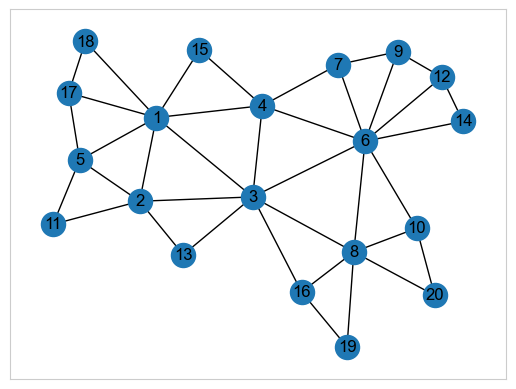

In [2]:
#Set-up of the model: loads the edge and triangle list
edg = pd.read_csv("NGF_edgelist.edges", sep=",", header=None, names=["node1", "node2"])

dft = pd.read_csv("NGF_triangles_d2.txt", sep=",", header=None, 
                 names=["node1", "node2","node3"])

list_triangles = np.array([sorted(j) for j in dft.values]) #sorts the triangles in growing order of nodes
edge_list = np.array([sorted(j) for j in edg.values]) #sorts the edges in growing order of nodes

G = nx.Graph()
G.add_edges_from(edge_list)

#coordinates for plots
pos={2: [-0.59533703, -0.14738193],
 1: [-0.5170788 ,  0.20015191],
 3: [-0.06676406, -0.12944249],
 4: [-0.02168739,  0.24963336],
 5: [-0.8755934 ,  0.02370859],
 15: [-0.31560822,  0.48066484],
 17: [-0.92662387,  0.3030341 ],
 18: [-0.84883785,  0.51619769],
 11: [-1.        , -0.24320687],
 13: [-0.3915684 , -0.36942436],
 6: [0.45853256, 0.10180383],
 8: [ 0.40587098, -0.35800884],
 16: [ 0.16184932, -0.5244383 ],
 7: [0.3318786 , 0.42005408],
 9: [0.61108739, 0.47384349],
 10: [ 0.69931267, -0.25930157],
 12: [0.81670007, 0.36825933],
 14: [0.9160782 , 0.18433844],
 19: [ 0.3741157 , -0.75248103],
 20: [ 0.78367354, -0.53800427]}

nx.draw_networkx(G,pos)

T=len(list_triangles)
L=len(edge_list)
N=G.number_of_nodes()

In [4]:
B1 = get_B1(edge_list) #edge list given should have all edges ordered with n1<n2.
B2 = get_B2(edge_list,list_triangles)

#create Dirac operator
D1, D2 = get_D(B1,B2) # builds the Diracs

w1, v1 = np.linalg.eigh(D1) # eigenvalues and eigenvectors
w2, v2 = np.linalg.eigh(D2)

np.allclose(D1,v1.dot(np.diag(w1).dot(np.linalg.inv(v1)))) #check

True

# Visualisations on the simplicial complex


In [9]:
D_one = False #True for D1 signal processing, and False for D2 signal processing.

#linear decomposition
w = w1 if D_one==True else w2
v = v1 if D_one==True else v2
D = D1 if D_one==True else D2
vinv = np.linalg.inv(v)

In [10]:
#build the signal:
beta=0.7
s_true, s_noisy, m_target ,snr = build_signals(w,v,D, x_min = True, beta=beta, gaussian=False)

#parameters for optimisation
gamma=10
tol = 0.0001
m_0 = 1.6 if D_one == False else 1.1
eps = 0.1

#optimising m
list_m, list_error_m, list_it, m, s_est_m = optimize_m(w,v,vinv,D,s_noisy,s_true,m_0,gamma,tol, epsilon = eps)
low, *_, high = sorted((np.concatenate((s_true,s_est_m,s_noisy)))) #used later to set the scale for the colormap
print(snr, beta, gamma, tol, m_0, np.linalg.norm(s_true-s_est_m))

1.4393985342058486 0.7 10 0.0001 1.6 0.20694943570250948


In [11]:
#colormap definition
if D_one == False:
    the_map=palettable.scientific.diverging.Berlin_20.mpl_colormap
    prova=mpl.cm.get_cmap(the_map,12)

    jc1=np.concatenate((np.linspace(0,0.25,120),np.linspace(0.26,0.495,7)),axis=0)
    jc2=np.concatenate((np.linspace(0.505,0.74,10),np.linspace(0.75,1.0,120)),axis=0)

    jc=np.concatenate((jc1,jc2),axis=0)
    prova2=prova(jc)
    the_map = ListedColormap(prova2)
    norm = mpl.colors.SymLogNorm(linthresh = 0.2, linscale = 10, vmin=-max(abs(low),high), vmax=max(abs(low),high), clip = True,base = 10)

else:
    the_map=palettable.scientific.diverging.Berlin_20.mpl_colormap
    norm = mpl.colors.SymLogNorm(linthresh = 0.005, linscale = 1, vmin=-max(abs(low),high), vmax=max(abs(low),high), clip = True,base = 10)

/var/folders/pq/mypssjvs1xs0k9vkzrrw07b00000gn/T/ipykernel_24122/1972817571.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  prova=mpl.cm.get_cmap(the_map,12)


1.4393985342058486 0.7 10 0.0001 1.6 0.20694943570250948


/Users/admin/Dropbox/PhD/Dirac_Signal_processing/code m/github/Functions_Dirac_signal_proc.py:424: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  edges = nx.draw_networkx_edges(


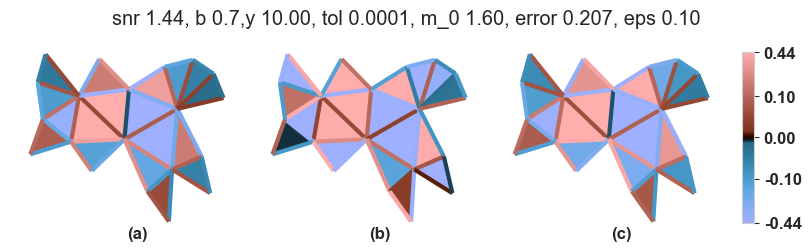

In [12]:
%matplotlib inline

plot_func = plot_NL if D_one ==True else plot_LTv1

rcParams['lines.linewidth'] = 2
font = {'weight' : 'bold',
        'size'   : 12}
faces = list_triangles
matplotlib.rc('font', **font)

fig = plt.figure(figsize = (8, 2.4), constrained_layout=True)

gs = GS(1, 3, figure=fig, left=0.05, right=0.2, wspace=0.0, hspace=0)
ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=1))
ax2 = plt.subplot(gs.new_subplotspec((0, 1), colspan=1))
ax3 = plt.subplot(gs.new_subplotspec((0, 2), colspan=1))

plot_func(s_true, edge_list, faces, pos, ax1, norm, the_map, edge_width_factor = 10)
mapper = plot_func(s_noisy, edge_list, faces, pos, ax2, norm, the_map, edge_width_factor = 10)
plot_func(s_est_m, edge_list, faces, pos, ax3, norm, the_map, edge_width_factor = 10)

ax1.annotate('(a)',xy = (0.5, 0.005), xycoords = 'axes fraction')
ax2.annotate('(b)',xy = (0.5, 0.005), xycoords = 'axes fraction')
ax3.annotate('(c)',xy = (0.5, 0.005), xycoords = 'axes fraction')

cax = ax3.inset_axes([1.06, 0.08, 0.05, 0.845])

if low==0:
    plt.colorbar(mapper, ticks = np.linspace(low,high,5),format = '%.2f')
else:
    if D_one == False:

        ticks= [-max(abs(low),high),-0.1, 0, 0.1,max(abs(low),high)]
        color_bar = plt.colorbar(mapper, ticks =ticks, cmap = the_map, norm = norm, cax = cax, spacing = 'uniform', format = '%.2f')
    else: 
        ticks= np.concatenate((-np.geomspace(0.005, max(abs(low),high), 3)[::-1], [0], np.geomspace(0.005, max(abs(low),high), 3)))
        color_bar = plt.colorbar(mapper, ticks = ticks, cmap = the_map, norm = norm, cax = cax, spacing = 'uniform', format = '%.3f')
        #formatter = plt.LogFormatter(labelOnlyBase = False, linthresh = 0.005, minor_thresholds = (10, 0.4))
        
color_bar.ax.minorticks_off()
fig.suptitle('snr %.2f, b %.1f,y %.2f, tol %.4f, m_0 %.2f, error %.3f, eps %.2f' %(snr, beta, gamma, tol, m_0, np.linalg.norm(s_true-s_est_m),eps))

print(snr, beta, gamma, tol, m_0, np.linalg.norm(s_true-s_est_m))

# Colourmap in the plane gamma, alpha

In [ ]:
%matplotlib inline
rcParams['lines.linewidth'] = 2
font = {'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

x_min=[True,False,False] #Whether the eigenvector is with min or max eigenvalue
gaussian = [False, False,True] #whether the signal is a Gaussian convolution
Nit = 3
m_0 = [1,3,1.5]
list_gamma = np.linspace(0,5,25)
list_beta = np.linspace(0,1,25)
gamma_2d, beta_2d = np.meshgrid(list_gamma,list_beta)

fig = plt.figure(figsize = (8, 4), constrained_layout=True)

gs = GS(2, 3, figure=fig, left=0.05, right=0.2, wspace=0.0, hspace=0)

ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=1))
ax2 = plt.subplot(gs.new_subplotspec((0, 1), colspan=1))
ax3 = plt.subplot(gs.new_subplotspec((0, 2), colspan=1))
axtop = [ax1,ax2,ax3]
    
ax4 = plt.subplot(gs.new_subplotspec((1, 0), colspan=1))
ax5 = plt.subplot(gs.new_subplotspec((1, 1), colspan=1))
ax6 = plt.subplot(gs.new_subplotspec((1, 2), colspan=1))
axbot = [ax4,ax5,ax6]

norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)

for i in [0,1,2]:
    
    avg_error = grid_error_avg(True, x_min[i], gaussian[i], list_gamma, list_beta, D1, D2, Nit, m_0[i])
    print(max(avg_error.flatten()))
    pcm = axtop[i].contourf(beta_2d,gamma_2d,avg_error,cmap=mpl.cm.BuPu,levels = np.linspace(0,1,15),
             norm=norm)
    
    avg_error = grid_error_avg(False, x_min[i], gaussian[i], list_gamma, list_beta, D1, D2, Nit, m_0[i])
    print(max(avg_error.flatten()))
    pcm = axbot[i].contourf(beta_2d,gamma_2d,avg_error, cmap=mpl.cm.BuPu,levels = np.linspace(0,1,15),
             norm=norm)

fig.colorbar(pcm, ax=[ax3,ax6],format = '%.1f')
    
ax1.annotate('(a)',xy = (0.01,0.91), xycoords = 'axes fraction')
ax2.annotate('(b)',xy = (0.01,0.91), xycoords = 'axes fraction')
ax3.annotate('(c)',xy = (0.01,0.91), xycoords = 'axes fraction')
ax4.annotate('(d)',xy = (0.01,0.91), xycoords = 'axes fraction')
ax5.annotate('(e)',xy = (0.01,0.91), xycoords = 'axes fraction')
ax6.annotate('(f)',xy = (0.01,0.91), xycoords = 'axes fraction')

for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.tick_params('both',direction='out', labelsize =12, bottom=True, top=False, left=True, right=False)
    ax.yaxis.set_major_locator(plt.LinearLocator(6))
    ax.xaxis.set_major_locator(plt.LinearLocator(3))
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    #tickvals = ax.get_yticks()
    #ax.set_yticklabels([])
    #tickvals = ax.get_xticks()
    #ax.set_xticklabels([])

    for ax in axtop:
        tickvals = ax.get_xticks()
        ax.set_xticklabels([])
    for ax in [ax2,ax3,ax5,ax6]:
        tickvals = ax.get_yticks()
        ax.set_yticklabels([])  
    for ax in axbot:
        ax.set_xlabel(r'$\alpha$',labelpad =0)
        
ax1.set_ylabel(r'$\tau$',labelpad =0)
ax4.set_ylabel(r'$\tau$',labelpad =0)


time 2.423560291994363 snr at beta = 2 0.8938254333344484
time 2.662526790983975 snr at beta = 2 0.5995563642705494
time 4.748186124954373 snr at beta = 2 1.0530996822346006
1.1078873041198665
time 3.7220493340864778 snr at beta = 2 0.8044373300704399
time 3.762983708991669 snr at beta = 2 0.75415718116424
time 3.169206332997419 snr at beta = 2 1.081467612078791
1.0760190147313082
time 2.6490494169993326 snr at beta = 2 0.8480034228041867
time 2.7511341659119353 snr at beta = 2 1.36248804809533
time 2.0124213329982013 snr at beta = 2 0.9346517315627683
0.9923353616914918
time 2.5721092079766095 snr at beta = 2 1.3426909573651418
time 2.921871625003405 snr at beta = 2 0.8425182673882806
time 2.933459458989091 snr at beta = 2 1.2873547986450373
0.944604979456255
time 3.7689757919870317 snr at beta = 2 0.8928974829348995
time 3.4892989590298384 snr at beta = 2 1.4528654700287604
time 3.106216499931179 snr at beta = 2 0.9522812397457836
0.9708869288435011
time 2.7178192919818684 snr at bet

# Convergence analysis

0
1


/var/folders/pq/mypssjvs1xs0k9vkzrrw07b00000gn/T/ipykernel_22449/911729118.py:117: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.2f}'.format(x) for x in tickvals])
/var/folders/pq/mypssjvs1xs0k9vkzrrw07b00000gn/T/ipykernel_22449/911729118.py:119: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,.1f}'.format(x) for x in tickvals])
/var/folders/pq/mypssjvs1xs0k9vkzrrw07b00000gn/T/ipykernel_22449/911729118.py:117: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.2f}'.format(x) for x in tickvals])
/var/folders/pq/mypssjvs1xs0k9vkzrrw07b00000gn/T/ipykernel_22449/911729118.py:119: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_tic

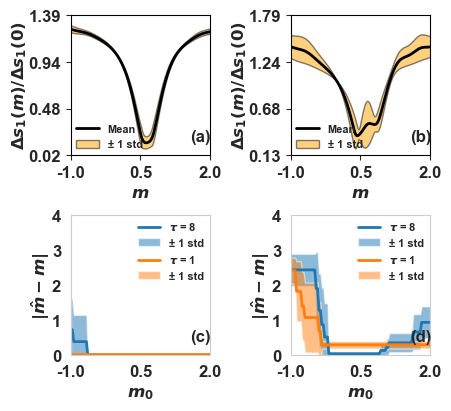

In [28]:
"""
Mass sweep and convergence analysis (Appendix A)
"""

rcParams['lines.linewidth'] = 2
font = {'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

D_one = True

fig = plt.figure(figsize = (4.4, 4), constrained_layout=True)

gs = GS(2, 2, figure=fig, left=0.05, right=0.2, wspace=0.0, hspace=0)
#ax1 = fig.add_subplot(gs[0,0:3])
ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=1))
ax2 = plt.subplot(gs.new_subplotspec((0, 1), colspan=1))
ax4 = plt.subplot(gs.new_subplotspec((1, 0), colspan=1))
ax5 = plt.subplot(gs.new_subplotspec((1, 1), colspan=1))

col1 = [ax1,ax2]
col2 = [ax4,ax5]


Nit=5
x_min = True

betas = [0.6, 1.5]
gammas = [8,8]
gammas_comp = [1,1]
list_error_m0 = dict()
list_m0diff = dict()
list_m0 = np.linspace(-1,2, 100)

w,v,D,vinv = get_wvd(D_one, D1, D2)

s = build_pure_signal(x_min, False, w, v, D)
s_true = s

m_true = ((np.transpose(s)).dot(D)).dot(s)/((np.transpose(s)).dot(s))

for i in [0,1]:
    beta = betas[i]
    gamma = gammas[i]
    gamma_comp = gammas_comp[i]
    print(i)
    ax2i = col1[i]
    
    error_avg, error_std, mass_avg, mass_std,list_mass = mass_sweep_avg_ratio(x_min, gamma, beta, Nit, w,v,vinv, D)
    ax2i.plot(list_mass,error_avg,'k', label = 'Mean')
    ax2i.fill_between(list_mass, error_avg-error_std,error_avg+error_std, color='orange', edgecolor = 'black', alpha=0.5,label = '± 1 std')
    
    list_error_m0[gamma] = np.empty([len(list_m0),Nit])
    list_m0diff[gamma] = np.empty([len(list_m0),Nit])
    list_error_m0[gamma_comp] = np.empty([len(list_m0),Nit])
    list_m0diff[gamma_comp] = np.empty([len(list_m0),Nit])
    
    for j in range(Nit):
        noise = get_noise(s, w, v, D) #returns a normalised noise vector in expectation
        s_noisy = s+beta*noise
        
        for k in range(len(list_m0)):
            m0 = list_m0[k]
            list_m, list_error, list_it, m, s_est_m = optimize_m(w,v,vinv,D,s_noisy,s_true,m0,gamma,0.0001)
            error_m = np.linalg.norm(s_true-s_est_m)
            list_error_m0[gamma][k,j] = error_m
            m_est= ((np.transpose(s_est_m)).dot(D)).dot(s_est_m)/((np.transpose(s_est_m)).dot(s_est_m))
            list_m0diff[gamma][k,j] = np.abs(m_true-m_est)
            
            list_m, list_error, list_it, m, s_est_m = optimize_m(w,v,vinv,D,s_noisy,s_true,m0,gamma_comp,0.0001)
            error_m = np.linalg.norm(s_true-s_est_m)
            list_error_m0[gamma_comp][k,j] = error_m
            m_est= ((np.transpose(s_est_m)).dot(D)).dot(s_est_m)/((np.transpose(s_est_m)).dot(s_est_m))
            list_m0diff[gamma_comp][k,j] = np.abs(m_true-m_est)
    
    
    list_error_m0avg = dict()
    list_error_m0std = dict()
    list_m0diffavg = dict()
    list_m0diffstd = dict()
    
    list_error_m0avg[gamma]= np.mean(list_error_m0[gamma], axis = 1)
    list_error_m0std[gamma]= np.std(list_error_m0[gamma], axis = 1)
    list_m0diffavg[gamma]= np.mean(list_m0diff[gamma], axis = 1)
    list_m0diffstd[gamma]= np.std(list_m0diff[gamma], axis = 1)
    list_error_m0avg[gamma_comp]= np.mean(list_error_m0[gamma_comp], axis = 1)
    list_error_m0std[gamma_comp]= np.std(list_error_m0[gamma_comp], axis = 1)
    list_m0diffavg[gamma_comp]= np.mean(list_m0diff[gamma_comp], axis = 1)
    list_m0diffstd[gamma_comp]= np.std(list_m0diff[gamma_comp], axis = 1)
        
    col2[i].plot(list_m0, list_m0diffavg[gamma], label = r'$\tau$ = %s'%gamma)
    col2[i].fill_between(list_m0, list_m0diffavg[gamma] - list_m0diffstd[gamma], list_m0diffavg[gamma] + list_m0diffstd[gamma], alpha = 0.5, label = '± 1 std')
    col2[i].plot(list_m0, list_m0diffavg[gamma_comp], label = r'$\tau$ = %s'%gamma_comp)
    col2[i].fill_between(list_m0, list_m0diffavg[gamma_comp] - list_m0diffstd[gamma_comp], list_m0diffavg[gamma_comp] + list_m0diffstd[gamma_comp], alpha = 0.5, label = '± 1 std')

    
ax1.annotate('(a)',xy = (0.86, 0.1), xycoords = 'axes fraction')
ax2.annotate('(b)',xy = (0.86, 0.1), xycoords = 'axes fraction')
ax4.annotate('(c)',xy = (0.86, 0.1), xycoords = 'axes fraction')
ax5.annotate('(d)',xy = (0.86, 0.1), xycoords = 'axes fraction')

for ax in [ax1,ax2]:
    ax.set_xlabel('$m$')
    ax.set_ylabel('$\Delta s_1(m)/\Delta s_1(0)$',labelpad =0)
    ax.tick_params('both',direction='out', labelsize =12, bottom=True, top=False, left=True, right=False)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.set_xlim([-1,2])
    #ax.set_ylim([0.1,2.5])
    ax.yaxis.set_major_locator(plt.LinearLocator(4))
    ax.xaxis.set_major_locator(plt.LinearLocator(3))

    tickvals = ax.get_yticks()
    ax.set_yticklabels(['{:,.2f}'.format(x) for x in tickvals])
    tickvals = ax.get_xticks()
    ax.set_xticklabels(['{:,.1f}'.format(x) for x in tickvals])
    ax.legend(frameon=False, borderpad= 0,loc=3, fontsize = 8, ncol=1)

for ax in col2:
    ax.legend(ncol = 1, frameon = False)
    ax.set_xlabel('$m_0$')
    ax.set_ylabel('$|\hat{m}-m|$',labelpad =0)
    ax.set_xlim([-1,2])
    ax.set_ylim([0,4])
    ax.yaxis.set_major_locator(plt.LinearLocator(5))
    ax.xaxis.set_major_locator(plt.LinearLocator(3))

    tickvals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0f}'.format(x) for x in tickvals])
    tickvals = ax.get_xticks()
    ax.set_xticklabels(['{:,.1f}'.format(x) for x in tickvals])
    ax.legend(frameon=False, borderpad= 0, fontsize = 8, ncol=1)


ax4.set_xlabel('$m_1^{(0)}$')
ax5.set_xlabel('$m_1^{(0)}$')



In [ ]:
#to edit limits of the axis
ax1.set_ylim([0,1.5])
ax1.yaxis.set_major_locator(plt.LinearLocator(4))
tickvals = ax1.get_yticks()
ax1.set_yticklabels(['{:,.1f}'.format(x) for x in tickvals])

ax2.set_ylim([0,1.8])
ax2.yaxis.set_major_locator(plt.LinearLocator(4))
tickvals = ax2.get_yticks()
ax2.set_yticklabels(['{:,.1f}'.format(x) for x in tickvals])
